In [1]:
import os, logging, argparse, torch

import torch.distributed as dist

from socket import gethostname
from torch.distributed.elastic.multiprocessing.errors import record

from jointformer.configs.task import TaskConfig
from jointformer.configs.model import ModelConfig
from jointformer.configs.trainer import TrainerConfig
from jointformer.configs.logger import LoggerConfig

from jointformer.utils.datasets.auto import AutoDataset
from jointformer.utils.tokenizers.auto import AutoTokenizer
from jointformer.models.auto import AutoModel
from jointformer.utils.loggers.auto import AutoLogger

from jointformer.trainers.trainer import Trainer

from jointformer.utils.runtime import set_seed, create_output_dir, set_to_dev_mode, log_args, dump_configs
from jointformer.utils.ddp import init_ddp, end_ddp
from jointformer.utils.data_collators import DataCollator
from tqdm import tqdm

%load_ext autoreload
%autoreload 2


In [2]:
cd ../..

/home/adamizdebski/projects/jointformer


In [3]:
DATA_DIR = "/home/adamizdebski/projects/jointformer_results/data"
CKPT_FILEPATH = "/home/adamizdebski/projects/jointformer_results/results/lm/no_separate_token/shared_emb/bs_512/drop_2/seed_1337/ckpt.pt"
PATH_TO_TASK_CONFIG = 'configs/tasks/guacamol/physchem'
PATH_TO_MODEL_CONFIG = 'configs/models/jointformer'
PATH_TO_TRAINER_CONFIG = 'configs/trainers/joint'
PATH_TO_LOGGER_CONFIG = None

In [4]:
task_config = TaskConfig.from_config_file(PATH_TO_TASK_CONFIG)
model_config = ModelConfig.from_config_file(PATH_TO_MODEL_CONFIG)
trainer_config = TrainerConfig.from_config_file(PATH_TO_TRAINER_CONFIG)
logger_config = LoggerConfig.from_config_file(PATH_TO_LOGGER_CONFIG) if PATH_TO_LOGGER_CONFIG else None

In [5]:
test_dataset = AutoDataset.from_config(task_config, split='test', data_dir=DATA_DIR)
tokenizer = AutoTokenizer.from_config(task_config)

In [6]:
#todo: store model config inside the checkpoint

model = AutoModel.from_config(model_config)
trainer = Trainer(
    seed=1337,
    config=trainer_config,
    model=model,
    tokenizer=tokenizer,
    test_dataset=test_dataset
) 
trainer._init_data_loaders()
trainer.resume_from_file(CKPT_FILEPATH)
  

INFO: number of parameters: 14.92M
INFO: Random seed set to 1337
INFO: num decayed parameter tensors: 37, with 14,948,608 parameters
INFO: num non-decayed parameter tensors: 19, with 4,808 parameters
INFO: using fused AdamW: True
INFO: tokens per iteration set to: 65,536


In [7]:
perplexities = []
trainer.model.eval()

with torch.no_grad():
    for idx, inputs in tqdm(enumerate(trainer.test_loader)):
        if trainer.device_type != 'cpu':
            for key, value in inputs.items():
                if value is not None and not isinstance(value, str):
                    inputs[key] = value.pin_memory().to(trainer.device, non_blocking=True)
        perplexities.extend(trainer.model.calculate_perplexity(**inputs).tolist())

467it [02:24,  3.22it/s]


In [8]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
PATH_TO_NON_TEST_DATASET = "/home/adamizdebski/projects/jointformer_results/data/moses/test_scaffolds.csv"

In [12]:
df = pd.read_csv(PATH_TO_NON_TEST_DATASET)

In [13]:
df

,version https://git-lfs.github.com/spec/v1
0,oid sha256:8bc942dd807147e07b506151fe8675f5878...
1,size 9195363


In [9]:
import requests
import pandas as pd

url = "https://media.githubusercontent.com/media/molecularsets/moses/master/data/dataset_v1.csv"
response = requests.get(url)

if response.status_code == 200:
    with open("data.csv", "wb") as file:
        file.write(response.content)
        file.seek(0)
        df = pd.read_csv("data.csv")
else:
    print("Failed to download the file.")

In [10]:
smiles_test_scaffold = df[df['SPLIT'] == 'test_scaffolds']['SMILES'].to_list()

In [11]:
smiles_test_scaffold

['O=C(C1CCCCC1)N1CC(=O)N2CCCc3ccccc3C2C1',
 'COc1ccccc1OC(=O)c1ccccc1OC(C)=O',
 'COc1ccc(OC)c(Cc2cnc3nc(N)nc(N)c3c2C)c1',
 'CC(=O)Nc1ccc(OC(=O)c2ccccc2O)cc1',
 'Cc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1)=NC2',
 'CC(=O)Nc1ccc(OC(=O)c2ccccc2OC(C)=O)cc1',
 'O=c1[nH]c(=O)n(C2CC(O)C(CO)O2)cc1Br',
 'Oc1c(Br)cc(Br)c2cccnc12',
 'OCCN(CCO)c1nc(-c2ccccc2)c(-c2ccccc2)o1',
 'Clc1ccc2c(c1)C(c1ccccc1)=NCc1nncn1-2',
 'Cc1cn(C2OC(CO)C(O)C2F)c(=O)[nH]c1=O',
 'Cc1csc(=NS(=O)(=O)c2ccc(N)cc2)[nH]1',
 'Cc1ncc(Cn2c(C)c(CCO)sc2=O)c(N)n1',
 'Cc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1Cl)=NC2',
 'O=c1[nH]c(=O)n(C2CC(O)C(CO)O2)cc1C(F)(F)F',
 'Oc1c(Br)cc(Cl)c2cccnc12',
 'Nc1nc(N)nc(-c2cc(Cl)ccc2Cl)n1',
 'CC1(F)OC(n2cc(F)c(=O)[nH]c2=O)C(O)C1O',
 'COc1ccc(O)cc1Cc1cnc2nc(N)nc(N)c2c1C',
 'O=c1[nH]c(=O)n(C2CC(F)C(CO)O2)cc1Cl',
 'Cc1oncc1C(=O)Nc1ccc(C(F)(F)F)cc1',
 'COc1cccc(Cn2nc3oc(=O)cc(C)c3c2C)c1',
 'NC(=O)c1[nH]c2ccc(Cl)cc2c1S(=O)(=O)c1ccccc1',
 'Cc1nnc2n1-c1ccc(Cl)cc1C(c1cccc(O)c1)=NC2',
 'Cc1cn2c(n1)Cc1ccc(Cl)cc1C(c1ccc(N)cc1)=N2'

In [12]:
from jointformer.utils.datasets.smiles.base import SmilesDataset

smiles_dataset = SmilesDataset(data=smiles_test_scaffold)
collator = DataCollator(tokenizer=tokenizer, tasks={'lm': 1})
loader = torch.utils.data.DataLoader(
                smiles_dataset,
                batch_size=512,
                num_workers=4,
                pin_memory=True,
                shuffle=False,
                collate_fn=collator
            )


In [13]:
perplexities_nontest = []
with torch.no_grad():
    for idx, inputs in tqdm(enumerate(loader)):
        if trainer.device_type != 'cpu':
            for key, value in inputs.items():
                if value is not None and not isinstance(value, str):
                    inputs[key] = value.pin_memory().to(trainer.device, non_blocking=True)
        perplexities_nontest.extend(trainer.model.calculate_perplexity(**inputs).tolist())

345it [01:50,  3.13it/s]


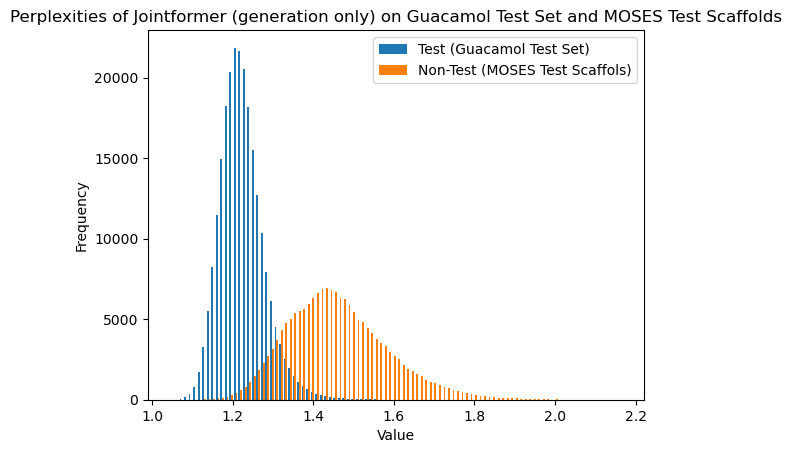

In [14]:
import matplotlib.pyplot as plt


# Plotting the histogram
plt.hist([perplexities, perplexities_nontest], label=['Test (Guacamol Test Set)', 'Non-Test (MOSES Test Scaffols)'], bins=100)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Perplexities of Jointformer (generation only) on Guacamol Test Set and MOSES Test Scaffolds')
plt.legend()

# Display the plot
plt.show()

In [ ]:
# Show that the ones passing filters have lower perplexity. 

In [85]:
import matplotlib.pyplot as plt


# Plotting the histogram
plt.hist([perplexities, perplexities_nontest], label=['Test (Guacamol Test Set)', 'Non-Test (MOSES Test Scaffols)'], bins=100)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Perplexities of Jointformer on Guacamol Test Set and MOSES Test Scaffolds')
plt.legend()

# Display the plot
plt.show()

512